# Comparação de Modelos - Consumo Doméstico

Agrega métricas e gráficos dos modelos SARIMAX, MLP, Random Forest e Híbrido. Salva tabela comparativa (MSE, RMSE, MAE, MAPE, R²) em out/solar_france.

         modelo       mse      rmse       mae        mape        r2  \
0       SARIMAX  1.272463  1.128035  1.000514  269.062140 -0.440912   
1           MLP       NaN       NaN       NaN         NaN       NaN   
2  RandomForest  0.014421  0.120087  0.054690    5.245968  0.983859   
3       Hibrido  1.364751  1.168225  1.043698  279.668472 -0.545417   

           aic          bic  train_rmse  test_rmse  train_mae  test_mae  \
0  2970.277625  3001.742871         NaN        NaN        NaN       NaN   
1          NaN          NaN    0.009872   0.050933   0.007077  0.043304   
2          NaN          NaN         NaN        NaN        NaN       NaN   
3          NaN          NaN         NaN        NaN        NaN       NaN   

   train_r2   test_r2  test_mape  cv_rmse_mean  cv_rmse_std  
0       NaN       NaN        NaN           NaN          NaN  
1  0.999942  0.997072   9.615198      0.203717     0.137708  
2       NaN       NaN        NaN           NaN          NaN  
3       NaN       Na

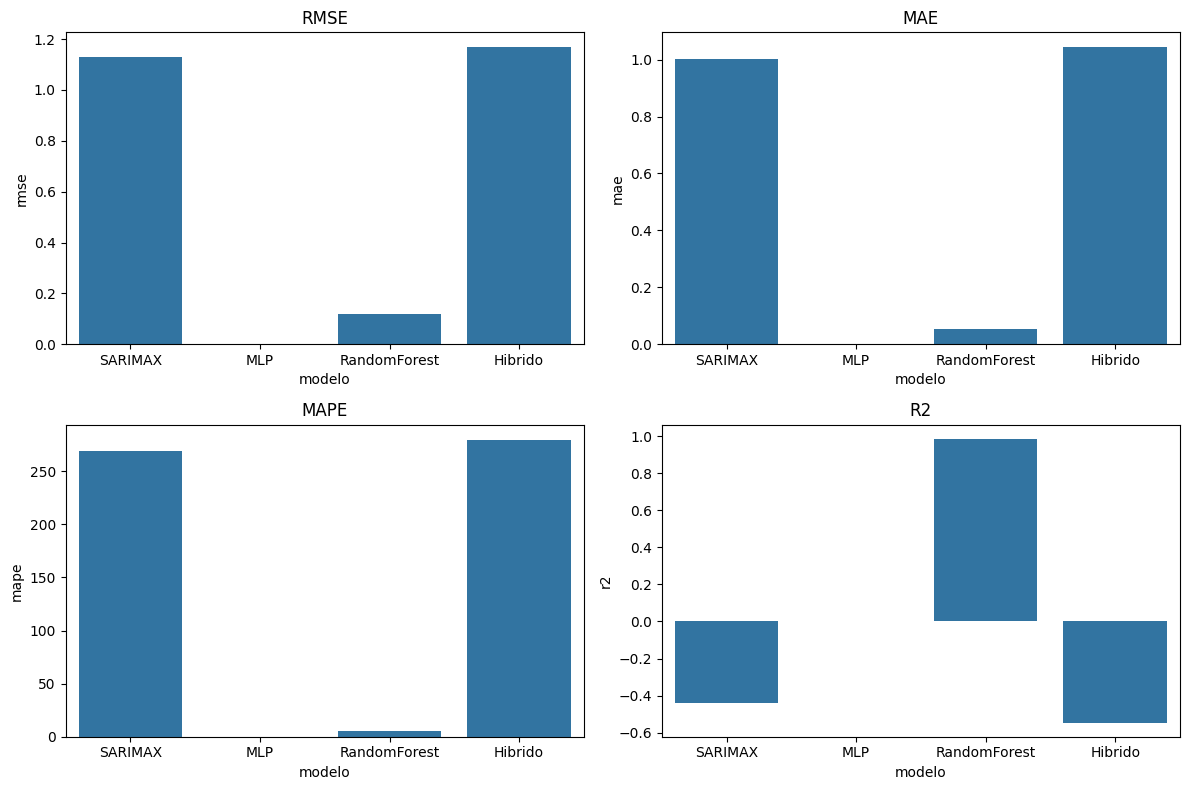

Melhor RMSE: RandomForest
Melhor MAPE: RandomForest


In [3]:
import pandas as pd, json, os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
base='../../out/household_consumption'
paths={
  'SARIMAX': os.path.join(base,'SARIMAX','sarimax_results.json'),
  'MLP': os.path.join(base,'MLP','mlp_results.json'),
  'RandomForest': os.path.join(base,'RandomForest','rf_results.json'),
  'Hibrido': os.path.join(base,'Hibrido','hybrid_results.json')
}
metrics=[]
for name,p in paths.items():
    if os.path.exists(p):
        try:
            d=json.load(open(p))
            m=d.get('metrics', d.get('sklearn_mlp',{}).get('metrics', {}))
            if m:
                metrics.append({'modelo':name, **m})
        except Exception as e:
            print('Erro lendo',name, e)

dfm=pd.DataFrame(metrics)
print(dfm)
comp_path=os.path.join(base,'comparacao_metricas.csv')
dfm.to_csv(comp_path, index=False)
print('Salvo em', comp_path)

# Bar plots
plt.figure(figsize=(12,8))
for i, col in enumerate(['rmse','mae','mape','r2']):
    if col in dfm.columns:
        plt.subplot(2,2,i+1); sns.barplot(data=dfm, x='modelo', y=col)
        plt.title(col.upper())
plt.tight_layout(); plt.savefig(os.path.join(base,'comparacao_metricas.png'), dpi=300); plt.show()

# Conclusão textual simples
if not dfm.empty:
    best_rmse_model = dfm.loc[dfm['rmse'].idxmin(),'modelo'] if 'rmse' in dfm else None
    best_mape_model = dfm.loc[dfm['mape'].idxmin(),'modelo'] if 'mape' in dfm else None
    print('Melhor RMSE:', best_rmse_model)
    print('Melhor MAPE:', best_mape_model)
    open(os.path.join(base,'comparacao_resumo.txt'),'w').write(
        f'Melhor RMSE: {best_rmse_model}\nMelhor MAPE: {best_mape_model}\n'
    )

In [4]:
# Insights: tendência e sazonalidade + texto de conclusão
import pandas as pd, numpy as np, os, json
from statsmodels.tsa.seasonal import seasonal_decompose

# carregar dados e analisar sazonalidade/trend
raw_path='../../data/household_consumption.xlsx'
df = pd.read_excel(raw_path, sheet_name='Sheet1')
df['Date and Hour']=pd.to_datetime(df['Date and Hour'])
df=df.set_index('Date and Hour').sort_index().dropna()
# reamostrar por hora (mais estável para decomposição)
df_h = df['Consumption'].resample('h').mean().dropna()

insights = []
try:
    dec = seasonal_decompose(df_h, model='additive', period=24)
    var_obs = np.var(dec.observed.dropna())
    var_sea = np.var(dec.seasonal.dropna())
    var_trd = np.var(dec.trend.dropna())
    var_res = np.var(dec.resid.dropna())
    seasonality_strength = max(0.0, 1 - var_res/ (var_res + var_sea + 1e-9))
    trend_strength = max(0.0, 1 - var_res/ (var_res + var_trd + 1e-9))
    insights.append(f'Força da sazonalidade (0-1): {seasonality_strength:.3f}')
    insights.append(f'Força da tendência (0-1): {trend_strength:.3f}')
except Exception as e:
    insights.append(f'Decomposição não concluída: {e}')

# inferir vantagens por modelo com base nas métricas coletadas
comp = pd.read_csv(os.path.join(base,'comparacao_metricas.csv')) if os.path.exists(os.path.join(base,'comparacao_metricas.csv')) else dfm
adv = []
if not comp.empty:
    # menores valores são melhores para rmse/mape/mae
    for col in ['rmse','mape','mae']:
        if col in comp.columns:
            adv.append(f'Melhor {col.upper()}: ' + comp.loc[comp[col].idxmin(),'modelo'])
    if 'r2' in comp.columns:
        adv.append(f'Melhor R²: ' + comp.loc[comp['r2'].idxmax(),'modelo'])

# heurística de recomendação
reco = []
if 'SARIMAX' in comp['modelo'].values:
    reco.append('SARIMAX tende a vantagem quando a sazonalidade/tendência é forte e o comportamento é próximo de linear.')
if 'MLP' in comp['modelo'].values:
    reco.append('MLP tende a capturar não-linearidades e interações entre lags e variáveis sazonais (codificação sen/cos).')
if 'RandomForest' in comp['modelo'].values:
    reco.append('Random Forest é robusto, bom para capturar relações não-lineares sem muita parametrização, mas pode suavizar picos.')
if 'Hibrido' in comp['modelo'].values:
    reco.append('Híbrido (ARIMA + MLP) combina componente linear + não-linear; costuma ir melhor quando há sazonalidade clara e padrões residuais complexos.')

texto = []
texto.append('=== Insights de Série ===')
texto.extend(insights)
texto.append('')
texto.append('=== Melhores modelos por métrica ===')
texto.extend(adv if adv else ['Sem métricas disponíveis'])
texto.append('')
texto.append('=== Recomendações práticas ===')
texto.extend(reco)

out_txt = os.path.join(base,'comparacao_insights.txt')
open(out_txt,'w', encoding='utf-8').write('\n'.join(texto))
print('\n'.join(texto))
print('Insights salvos em:', out_txt)

=== Insights de Série ===
Força da sazonalidade (0-1): 0.744
Força da tendência (0-1): 0.356

=== Melhores modelos por métrica ===
Melhor RMSE: RandomForest
Melhor MAPE: RandomForest
Melhor MAE: RandomForest
Melhor R²: RandomForest

=== Recomendações práticas ===
SARIMAX tende a vantagem quando a sazonalidade/tendência é forte e o comportamento é próximo de linear.
MLP tende a capturar não-linearidades e interações entre lags e variáveis sazonais (codificação sen/cos).
Random Forest é robusto, bom para capturar relações não-lineares sem muita parametrização, mas pode suavizar picos.
Híbrido (ARIMA + MLP) combina componente linear + não-linear; costuma ir melhor quando há sazonalidade clara e padrões residuais complexos.
Insights salvos em: ../../out/household_consumption\comparacao_insights.txt
